In [30]:
import keras.backend as K
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
from keras import optimizers
from keras.layers import Flatten,Input,Conv2D,MaxPooling2D,BatchNormalization,Activation,GlobalAveragePooling2D,ZeroPadding2D,Dense,Add,Dropout
from keras.models import Model
from keras.engine import get_source_inputs
from keras.utils import to_categorical, get_file
from keras.layers.merge import concatenate,add
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import keras
from distutils.version import StrictVersion

if StrictVersion(keras.__version__) < StrictVersion('2.2.0'):
    from keras.applications.imagenet_utils import _obtain_input_shape
else:
    from keras_applications.imagenet_utils import _obtain_input_shape

def build_resnet(
     repetitions=(2, 2, 2, 2),
     include_top=True,
     input_tensor=None,
     input_shape=None,
     classes=1000,
     block_type='usual'):

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=101,
                                      data_format='channels_last',
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape, name='data')
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    
    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    init_filters = 64

    if block_type == 'basic':
        conv_block = basic_conv_block
        identity_block = basic_identity_block
    else:
        conv_block = usual_conv_block
        identity_block = usual_identity_block
    
    # resnet bottom
    x = BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
    x = BatchNormalization(name='bn0', **bn_params)(x)
    x = Activation('relu', name='relu0')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    
    # resnet body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            
            filters = init_filters * (2**stage)
            
            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = conv_block(filters, stage, block, strides=(1, 1))(x)
                
            elif block == 0:
                x = conv_block(filters, stage, block, strides=(2, 2))(x)
                
            else:
                x = identity_block(filters, stage, block)(x)
                
    x = BatchNormalization(name='bn1', **bn_params)(x)
    x = Activation('relu', name='relu1')(x)

    # resnet top
    if include_top:
        x = GlobalAveragePooling2D(name='pool1')(x)
        x = Dense(classes, name='fc1')(x)
        x = Activation('softmax', name='softmax')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
        
    # Create model.
    model = Model(inputs, x)

    return model

In [2]:
def find_weights(weights_collection, model_name, dataset, include_top):
    w = list(filter(lambda x: x['model'] == model_name, weights_collection))
    w = list(filter(lambda x: x['dataset'] == dataset, w))
    w = list(filter(lambda x: x['include_top'] == include_top, w))
    return w

In [3]:
def load_model_weights(weights_collection, model, dataset, classes, include_top):
    weights = find_weights(weights_collection, model.name, dataset, include_top)

    if weights:
        weights = weights[0]

        if include_top and weights['classes'] != classes:
            raise ValueError('If using `weights` and `include_top`'
                             ' as true, `classes` should be {}'.format(weights['classes']))

        weights_path = get_file(weights['name'],
                                weights['url'],
                                cache_subdir='models',
                                md5_hash=weights['md5'])

        model.load_weights(weights_path)

    else:
        raise ValueError('There is no weights for such configuration: ' +
                         'model = {}, dataset = {}, '.format(model.name, dataset) +
                         'classes = {}, include_top = {}.'.format(classes, include_top))

In [4]:
def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc'
    return conv_name, bn_name, relu_name, sc_name


def basic_identity_block(filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer

Helper functions for Resnet34

In [5]:
def basic_conv_block(filters, stage, block, strides=(2, 2)):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        shortcut = Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer


def usual_conv_block(filters, stage, block, strides=(2, 2)):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '2', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)

        shortcut = Conv2D(filters*4, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer


def usual_identity_block(filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer


In [6]:
def get_conv_params(**params):
    default_conv_params = {
        'kernel_initializer': 'glorot_uniform',
        'use_bias': False,
        'padding': 'valid',
    }
    default_conv_params.update(params)
    return default_conv_params

def get_bn_params(**params):
    default_bn_params = {
        'axis': 3,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True,
    }
    default_bn_params.update(params)
    return default_bn_params

In [7]:
weights_collection = [
    # ResNet34
    {
        'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': True,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000.h5',
        'name': 'resnet34_imagenet_1000.h5',
        'md5': '2ac8277412f65e5d047f255bcbd10383',
    },

    {
        'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': False,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000_no_top.h5',
        'name': 'resnet34_imagenet_1000_no_top.h5',
        'md5': '8caaa0ad39d927cb8ba5385bf945d582',
    },
]

In [8]:
def ResNet34(input_shape, input_tensor=None, weights=None, classes=1000, include_top=True):
    model = build_resnet(input_tensor=input_tensor,
                         input_shape=input_shape,
                         repetitions=(3, 4, 6, 3),
                         classes=classes,
                         include_top=include_top,
                         block_type='basic')
    model.name = 'resnet34'

    if weights:
        load_model_weights(weights_collection, model, weights, classes, include_top)
    return model

Image processing and Data Collection

In [21]:
gestures = {'wave':'Hello',
            'pointup':'Volume_Up',
            'rockon':'Play',
            'pointright':'Next',
            'skip':'Next'
            }

gestures_map = {'Hello' : 0,
                'Volume_Up': 1,
                'Play': 2,
                'Next': 3,
                }

In [5]:
def process_image(path):
    img = Image.open(path)
    img = img.resize((224, 224))
    img = np.array(img)
    return img

def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype='float32')
    if rgb:
        pass
    else:
        X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data, num_classes=4)
    return X_data, y_data

def walk_file_tree(relative_path):
    X_data = []
    y_data = [] 
    for directory, subdirectories, files in os.walk(relative_path):
        for file in files:
            if not file.startswith('.') and (not file.startswith('C_')):
                path = os.path.join(directory, file)
                gesture_name = gestures[file.split('_')[0]]
                y_data.append(gestures_map[gesture_name])
                X_data.append(process_image(path))   

            else:
                continue

    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

class Data(object):
    def __init__(self):
        self.X_data = []
        self.y_data = []

    def get_data(self):
        return self.X_data, self.y_data

In [31]:
def augment_data(img_path, train_batch_size, directory, prefix, generation_count):
    try:
        test_datagen = ImageDataGenerator(rescale=1./255, 
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2) 

        x = load_img(img_path)
        x = img_to_array(x)
        x = x.reshape((1, ) + x.shape)

        i = 0
        for batch in test_datagen.flow(x, batch_size=train_batch_size,
                              save_to_dir=directory, save_prefix=prefix, save_format='png'):
            i += 1
            if i > generation_count:
                return 1
                break
    except:
        return 0

In [32]:
gesture_name = ['wave', 'pointup', 'rockon', 'pointright']

In [33]:
relative_path = './data/'
rgb = True
train_batch_size = 64
for i in range(4):
    img_len = (sum(np.argmax(y_data, axis=1) == i))
    for j in range(0, img_len, 10):
        img = gesture_name[i]
        file_path = './data' + gesture_name[i] + '_' + str(j) + '.png'
        res = augment_data(file_path, train_batch_size, '../data/aug', gesture_name[i]+'_' + str(j), 2)
X_data, y_data = walk_file_tree(relative_path)

Inspecting Data

In [29]:
# go = np.array(y_data)
# count = np.bincount(go)
print(y_data.shape)
print(np.sum(y_data[:,0]))
print(np.sum(y_data[:,1]))
print(np.sum(y_data[:,2]))
print(np.sum(y_data[:,3]))

(5240, 4)
1776.0
1534.0
737.0
1193.0


In [ ]:
sample = np.random_integers(0, high=X_data.shape[0], size=None)¶
for i in sample:
    plt.plot(X_data[i])
    plt.show()

In [14]:
print('X_data shape:' + str(X_data.shape))
print('y_data shape:' + str(y_data.shape))
print(y_data)

X_data shape:(5240, 224, 224, 3)
y_data shape:(5240, 4)
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


In [18]:
# X_train_rgb, X_test_rgb, y_train_rgb, y_test_rgb = train_test_split(image_rgb, y_data, test_size = 0.2, random_state=12, stratify=y_data)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=12, stratify=y_data)

In [16]:
file_path = './models/test_model.h5'
imageSize = 224

In [18]:
mode1 = ResNet34(input_shape=(imageSize, imageSize, 3), weights='imagenet', classes=1000,include_top=False)
optimizer1 = optimizers.Adam()

base_model = mode1  # Topless
# Add top layer
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='fc4')(x)

predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Train top layer
for layer in base_model.layers:
    layer.trainable = False

# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.Adam(),
#               metrics=[keras.metrics.Accuracy, keras.metrics.FalsePositives, keras.metrics.FalseNegatives, keras.metrics.Recall])

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test), verbose=1)


Train on 4192 samples, validate on 1048 samples
Epoch 1/3
4192/4192 [==============================] - 579s 138ms/step - loss: 0.8281 - accuracy: 0.7579 - val_loss: 2.9251 - val_accuracy: 0.2281
Epoch 2/3
4192/4192 [==============================] - 570s 136ms/step - loss: 0.0895 - accuracy: 0.9688 - val_loss: 3.1398 - val_accuracy: 0.2281
Epoch 3/3
4192/4192 [==============================] - 568s 136ms/step - loss: 0.0623 - accuracy: 0.9816 - val_loss: 5.8852 - val_accuracy: 0.2281


In [27]:
model.save('models/new_temp.h5')

In [16]:
from keras.models import load_model

In [ ]:
model = load_model('models/new_temp.h5')
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1,)



Train on 4192 samples, validate on 1048 samples
Epoch 1/10
4192/4192 [==============================] - 538s 128ms/step - loss: 0.0457 - accuracy: 0.9874 - val_loss: 6.1479 - val_accuracy: 0.2281
Epoch 2/10
4192/4192 [==============================] - 512s 122ms/step - loss: 0.0480 - accuracy: 0.9854 - val_loss: 6.4994 - val_accuracy: 0.2281
Epoch 3/10
4192/4192 [==============================] - 505s 120ms/step - loss: 0.0494 - accuracy: 0.9881 - val_loss: 6.7842 - val_accuracy: 0.2281
Epoch 4/10
4192/4192 [==============================] - 504s 120ms/step - loss: 0.0167 - accuracy: 0.9948 - val_loss: 8.4781 - val_accuracy: 0.2281
Epoch 5/10
4192/4192 [==============================] - 505s 121ms/step - loss: 0.0244 - accuracy: 0.9931 - val_loss: 5.4172 - val_accuracy: 0.2281
Epoch 6/10
4192/4192 [==============================] - 508s 121ms/step - loss: 0.0474 - accuracy: 0.9878 - val_loss: 8.3667 - val_accuracy: 0.2281
Epoch 7/10
3008/4192 [====================>.........] - ETA: 1

In [ ]:
model.save('models/new_temp.h5')

In [34]:
model = load_model('models/new_temp.h5')
pred = model.predict(X_test)
predictions = np.argmax(pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)

In [35]:
print(classification_report(y_test_bool, predictions))
print(confusion_matrix(y_test_bool, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       355
           1       0.00      0.00      0.00       307
           2       0.00      0.00      0.00       147
           3       0.23      1.00      0.37       239

    accuracy                           0.23      1048
   macro avg       0.06      0.25      0.09      1048
weighted avg       0.05      0.23      0.08      1048

[[  0   0   0 355]
 [  0   0   0 307]
 [  0   0   0 147]
 [  0   0   0 239]]


/home/uditsharma025_gmail_com/.local/lib/python3.5/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1,)
model.save('models/new_temp.h5')


Train on 4192 samples, validate on 1048 samples
Epoch 1/10
4192/4192 [==============================] - 555s 132ms/step - loss: 0.0552 - accuracy: 0.9840 - val_loss: 6.5287 - val_accuracy: 0.2281
Epoch 2/10
4192/4192 [==============================] - 567s 135ms/step - loss: 0.0267 - accuracy: 0.9919 - val_loss: 4.5959 - val_accuracy: 0.2281
Epoch 3/10
4192/4192 [==============================] - 559s 133ms/step - loss: 0.0412 - accuracy: 0.9907 - val_loss: 3.5876 - val_accuracy: 0.2281
Epoch 4/10
4192/4192 [==============================] - 554s 132ms/step - loss: 0.0263 - accuracy: 0.9919 - val_loss: 4.3987 - val_accuracy: 0.2281
Epoch 5/10
4192/4192 [==============================] - 551s 132ms/step - loss: 0.0148 - accuracy: 0.9959 - val_loss: 4.6478 - val_accuracy: 0.2281
Epoch 6/10
4192/4192 [==============================] - 551s 132ms/step - loss: 0.0099 - accuracy: 0.9959 - val_loss: 5.3321 - val_accuracy: 0.2281
Epoch 7/10
4192/4192 [==============================] - 548s 131

TypeError: 'History' object is not subscriptable

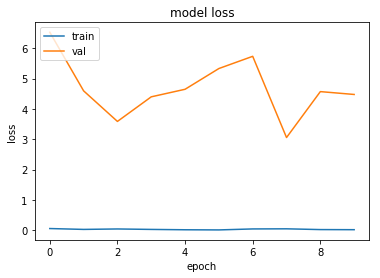

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Loss.png')

In [ ]:
model.save('models/new_temp.h5')

In [39]:
y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
print(np.bincount(y_pred_bool))
y_test_bool = np.argmax(y_test, axis=1)

print(classification_report(y_test_bool, y_pred_bool))
print(confusion_matrix(y_test_bool, y_pred_bool))

[   0    0    0 1048]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       355
           1       0.00      0.00      0.00       307
           2       0.00      0.00      0.00       147
           3       0.23      1.00      0.37       239

    accuracy                           0.23      1048
   macro avg       0.06      0.25      0.09      1048
weighted avg       0.05      0.23      0.08      1048

[[  0   0   0 355]
 [  0   0   0 307]
 [  0   0   0 147]
 [  0   0   0 239]]
